In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from collections import Counter

import clustering
import classification
import merge
import split
from text_preprocess import sentence_preprocess
from representation import SentBERT, Umap
from topic_analysis import word_cloud, common_words

warnings.filterwarnings("ignore", module="matplotlib\..*" )

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Omer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
CMAP = np.array(['red', 'green', 'gold', 'dodgerblue', 'purple', 'brown', 'grey', 'darkcyan',
                 'tomato', 'lightgreen', 'khaki', 'blue', 'pink', 'olive', 'black', 'cyan'])
CMAP_LEN = len(CMAP)

In [4]:
def color_mapping(current_labels):
    colors = dict()
    label_set = set(np.unique(current_labels))
    unused_indices = []
    for i in range(max(label_set) + 1):
        if i < CMAP_LEN:
            if i in label_set:
                colors[i] = CMAP[i]
            else:
                unused_indices.append(i)
        elif i in label_set:
            try:
                j = unused_indices.pop(0)
            except IndexError:
                print('Too many clusters', len(label_set))
                raise Exception
            colors[i] = CMAP[j]
    
    return colors           

In [5]:
def plot_scatter(embeddings, labels, title):
    # plot embeddings by labels
    cmap = color_mapping(labels)
    plt.figure(figsize=(10, 5))
    for label in np.unique(labels):
        plt.scatter(*embeddings[labels == label].T, c=cmap[label], label=label)
    plt.legend()
    plt.title(title)
    plt.show()

In [6]:
def plot_graph(G, first_timestep):
    # get attributes for plotting
    nodes_size = np.array(list(nx.get_node_attributes(G, 's').values())) * 15
    nodes_color = list(nx.get_node_attributes(G, 'c').values())
    nodes_labels = nx.get_node_attributes(G,'name')
    pos = nx.multipartite_layout(G, 't')

    # plot
    fig, ax = plt.subplots(figsize=(20,7))
    nx.draw(G, labels=nodes_labels, font_weight='bold', pos=pos, node_size=nodes_size,
            node_color=nodes_color, cmap='Wistia', ax=ax)

    # add x-axis with date ticks
    limits=plt.axis('on') # turns on axis
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(bottom=True, labelbottom=True)
    xticks = sorted(np.unique(np.array(list(pos.values())).T[0]))
    n_dates = len(xticks)
    ax.set_xticks(ticks=xticks, labels=data.iloc[first_timestep: first_timestep + n_dates]['date'].values, rotation=45)
    ax.set_xlabel('Date')
    
    plt.show()

In [7]:
def latest_version(G, node, OFFSET):
    return max([n for n in G.nodes if n % OFFSET == node])

In [8]:
data = pd.read_csv('BlackLivesMatter_revisions.csv')
data

,date,text
0,2015-03-08,Black Lives Matter is a U.S.-based internation...
1,2015-09-08,\nBlack Lives Matter is an activist movement i...
2,2016-03-09,\nBlack Lives Matter (BLM) is an international...
3,2016-09-10,\nBlack Lives Matter (BLM) is an international...
4,2017-03-12,\nBlack Lives Matter (BLM) is an international...
5,2017-09-13,\nBlack Lives Matter (BLM) is an international...
6,2018-03-18,\nBlack Lives Matter (BLM) is an international...
7,2018-09-19,\nBlack Lives Matter (BLM) is an international...
8,2019-04-11,\nBlack Lives Matter (BLM) is an international...
9,2019-10-18,\nBlack Lives Matter (BLM) is an international...


Recall from data_exploration notebook that in the first timesteps the number of sentences is relatively low.<br>
Since the Umap dimensionaility reducer is fitted only once on the data from the first timestep, it is crucial that it will have enough information to learn from.<br>
Therefore, we will start from the second timestep and not the first one (that has only ~20 sentences)
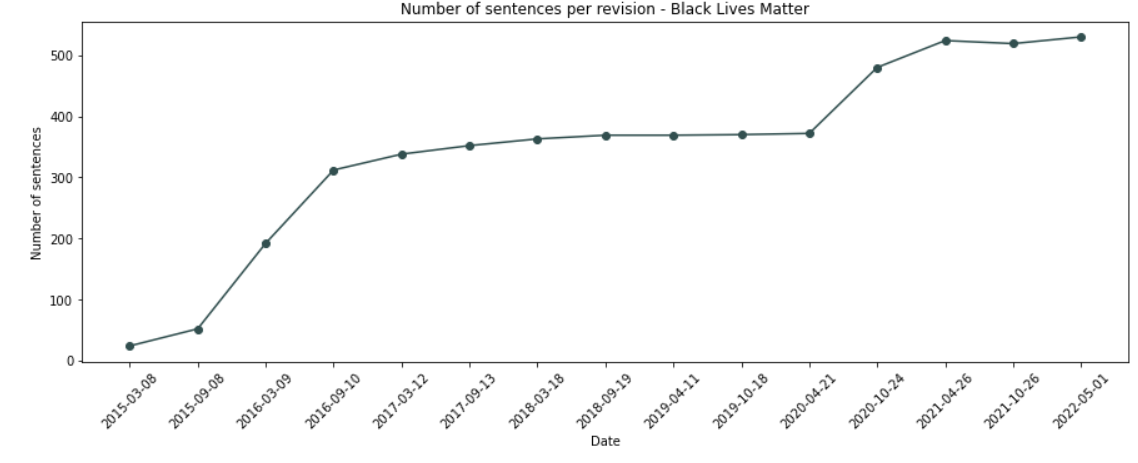

In [9]:
first_timestep = 2
OFFSET = 1000

## Cluster once
And define all models (SentBERT, Umap) once

In [10]:
# only data known so far is original (data[0])
data0 = data.iloc[first_timestep]

# text preprocess
sentences, clean_sentences = sentence_preprocess(data0['text'])

# embed
bert_model = SentBERT()
embeddings = bert_model.embed(clean_sentences)

# dimensionality reduction
d = 30
n = len(sentences)
umap_d = Umap(n_components=d, n_init_observations=n)
umap_2 = Umap(n_components=2, n_init_observations=n)
embeddings_d = umap_d.fit_transform(embeddings)
embeddings_2 = umap_2.fit_transform(embeddings)

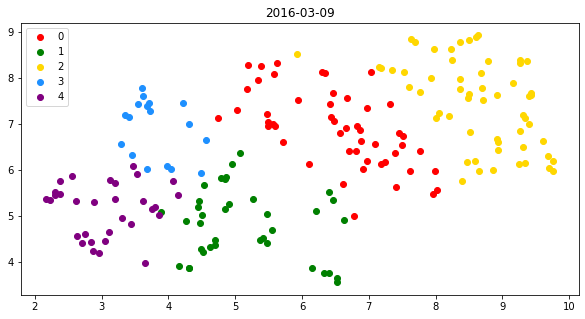

In [11]:
# cluster
k = 5
clusterer = clustering.KMeansClustering(k=k)
clusterer.fit(embeddings_d)
labels = clusterer.get_labels()

# fit a classifier based on current clusters (for next timestep)
classifier = classification.SVMClassifier()
classifier.fit(embeddings_d, labels)

# how a direct clustering would have performed on current data?
k = len(np.unique(labels))
clusterer = clustering.KMeansClustering(k=k)
clusterer.fit(embeddings_d)
possible_labels = clusterer.get_labels()
k = 5
clusterer = clustering.KMeansClustering(k=k)
clusterer.fit(embeddings_d)
possible5_labels = clusterer.get_labels()

# evaluate clustering methods
sil = [silhouette_score(embeddings_d, labels)]
possible_sil = [silhouette_score(embeddings_d, possible_labels)]
possible5_sil = [silhouette_score(embeddings_d, possible5_labels)]

# save relevant information in a graph
counter = Counter(labels)
G = nx.DiGraph()
G.add_nodes_from([(i, 
                   {'t': first_timestep,
                    'c': first_timestep,
                    's': counter[i],
                    'name': i
                   }) for i in range(k)])

# plot
plot_scatter(embeddings_2, labels, data0['date'])

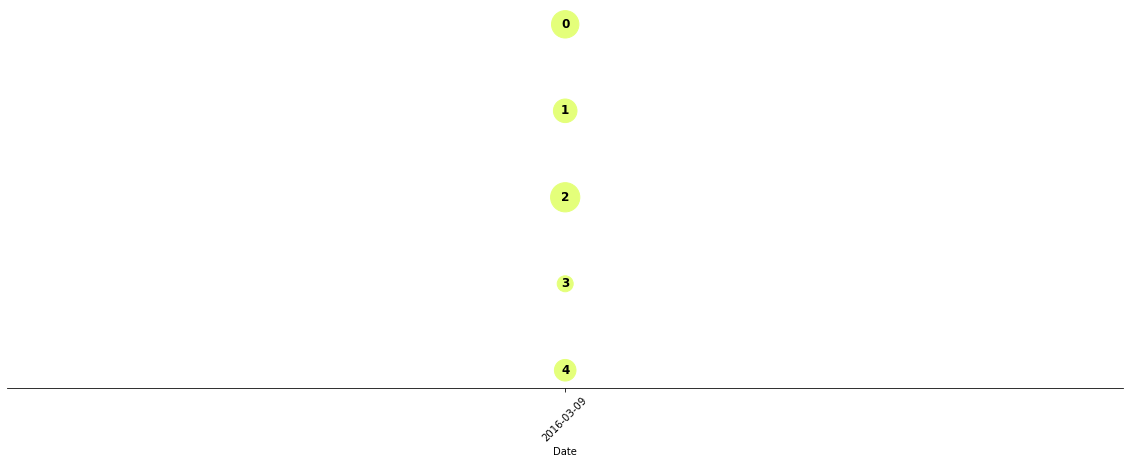

In [12]:
plot_graph(G, first_timestep)

topic 0


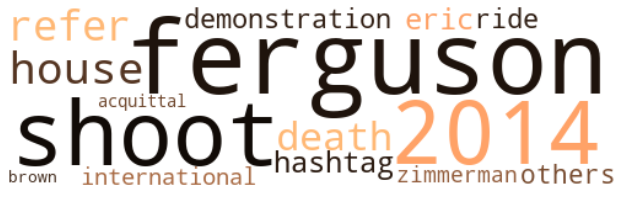

topic 3


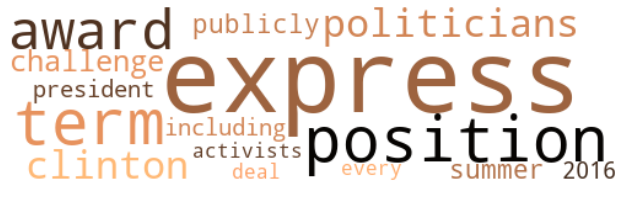

In [13]:
common = common_words(clean_sentences, labels, k=15)
for topic in [0, 3]:
    print(f'topic {topic}')
    word_cloud(common[topic])

## Adjust clusters dynamically
Any timestep a new "stream" of text is an input, which we called the *after* text.<br>
Same steps of preprocess as above are performed (clean sentences, embed).<br>
Afterwards, instead of clustering independently of the *before* clustering, adjust clusters by:
* predicting
* merging
* splitting

At the end, save some results, and train a classifier based on adjusted clustering, for next timestep to use.

4 optional splits (by volume criterion), only {2: (7, 8), 3: (9, 10)} splits performed.


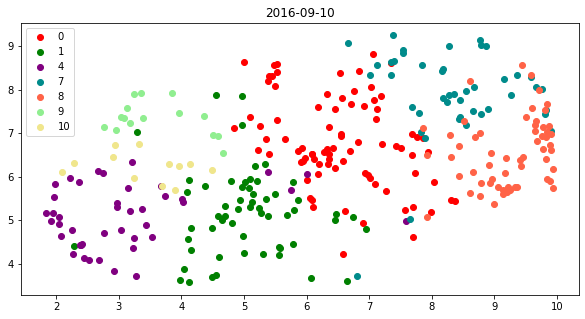

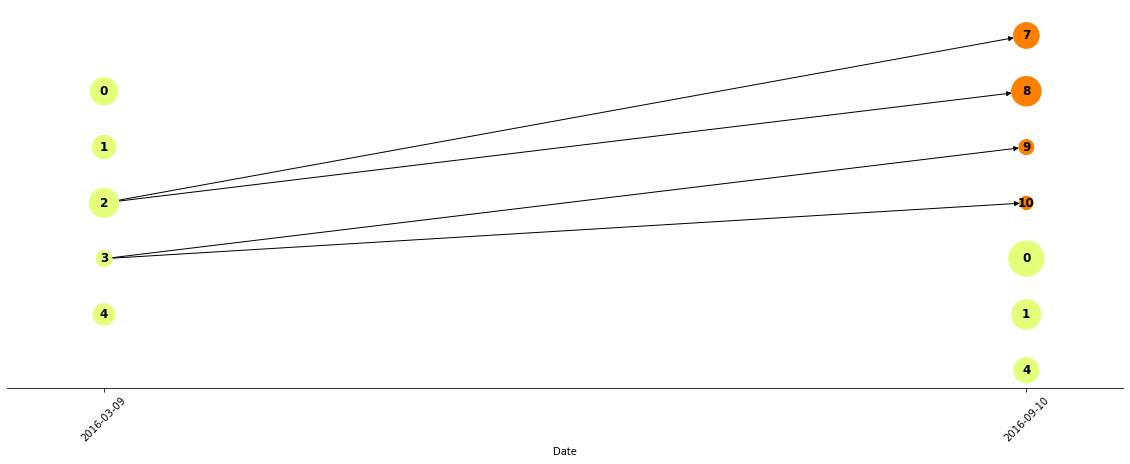

4 optional splits (by volume criterion), only {} splits performed.


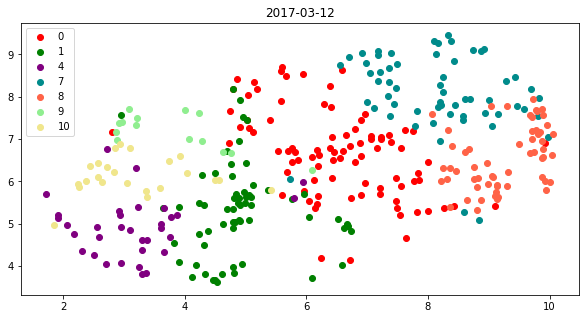

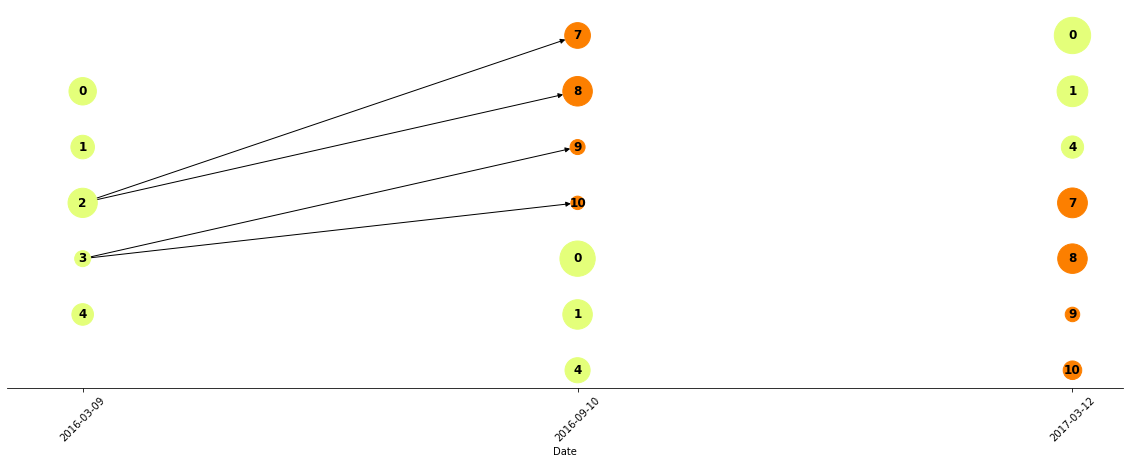

3 optional splits (by volume criterion), only {} splits performed.


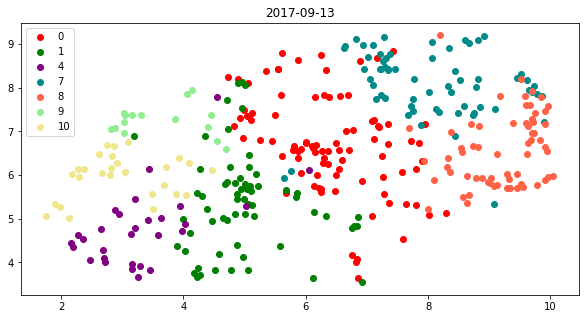

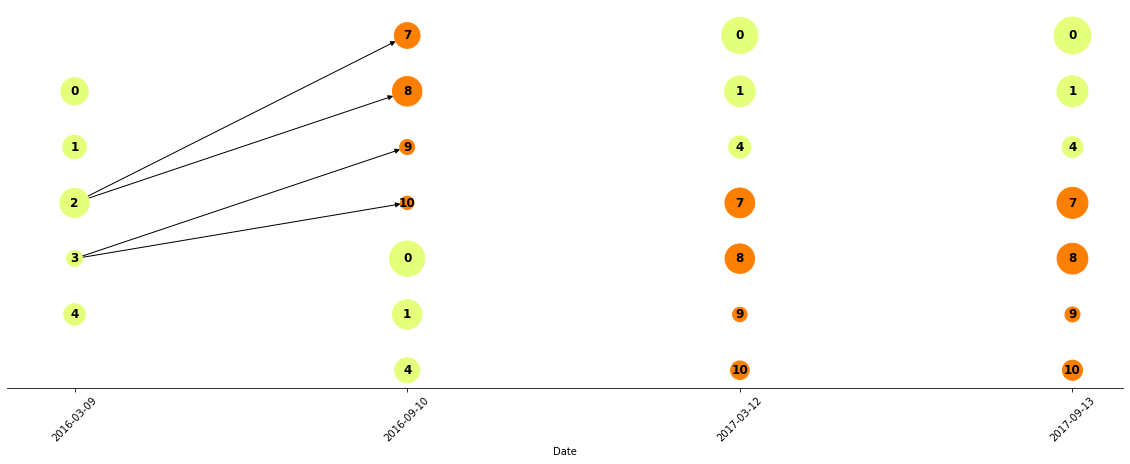

3 optional splits (by volume criterion), only {} splits performed.


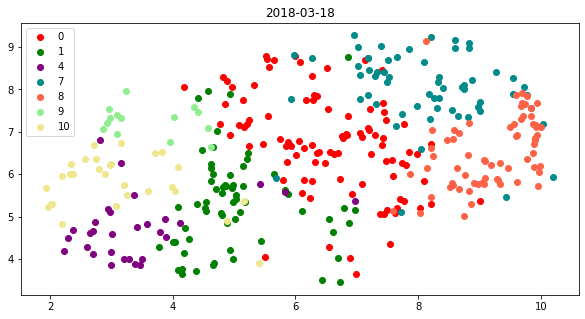

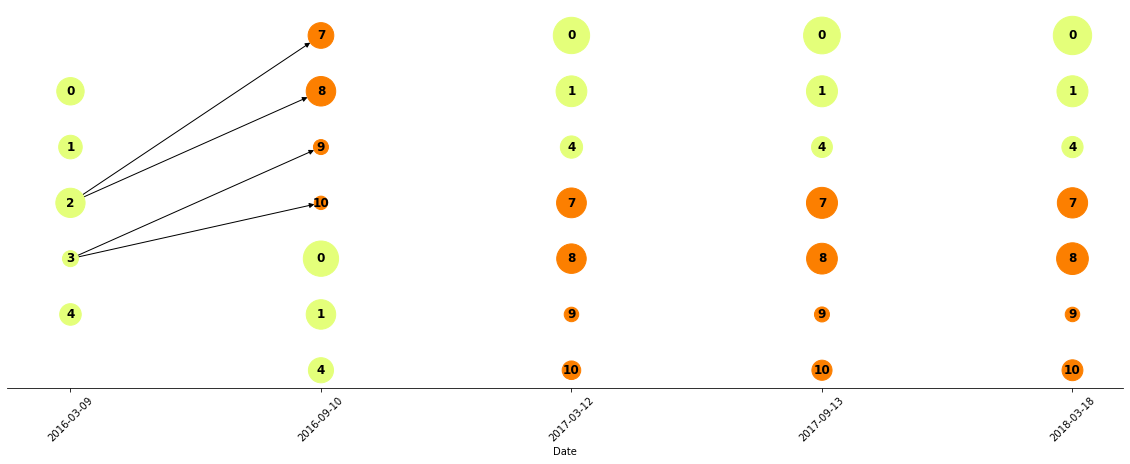

3 optional splits (by volume criterion), only {} splits performed.


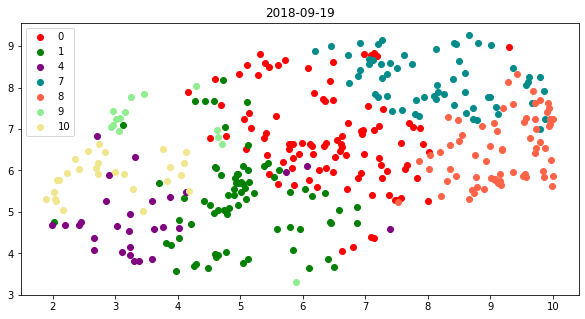

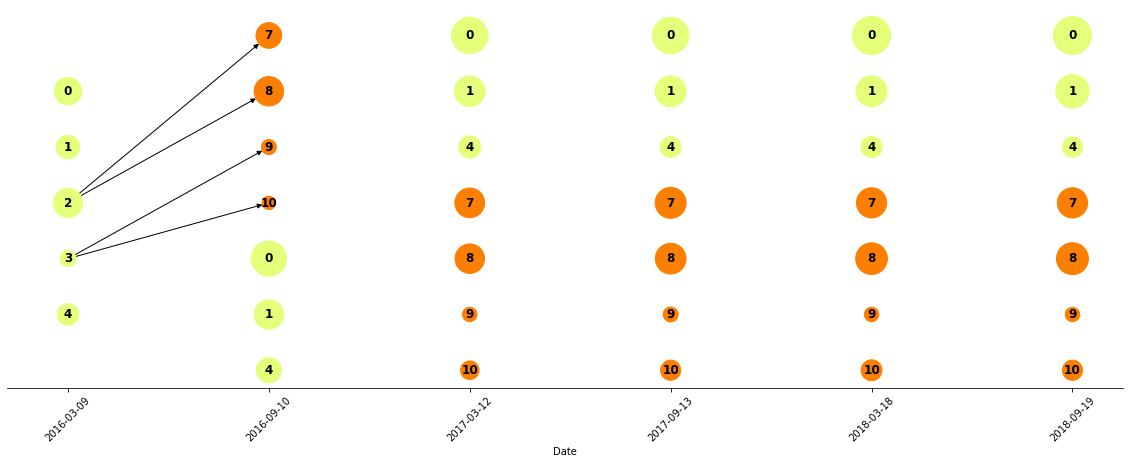

3 optional splits (by volume criterion), only {0: (12, 13)} splits performed.


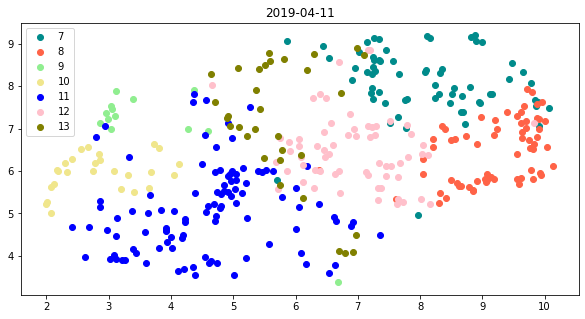

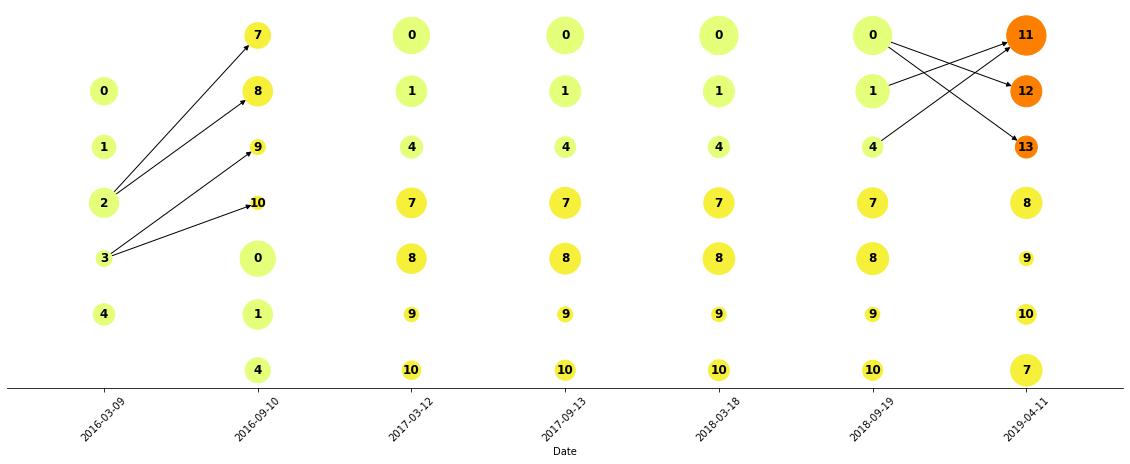

4 optional splits (by volume criterion), only {14: (20, 21)} splits performed.


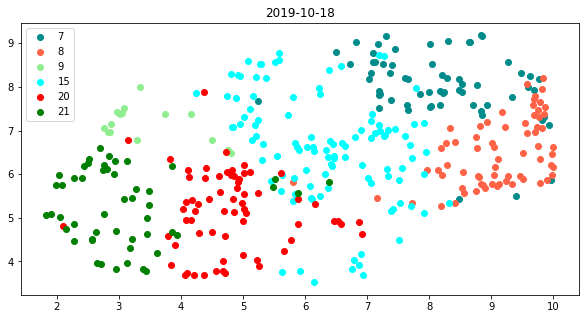

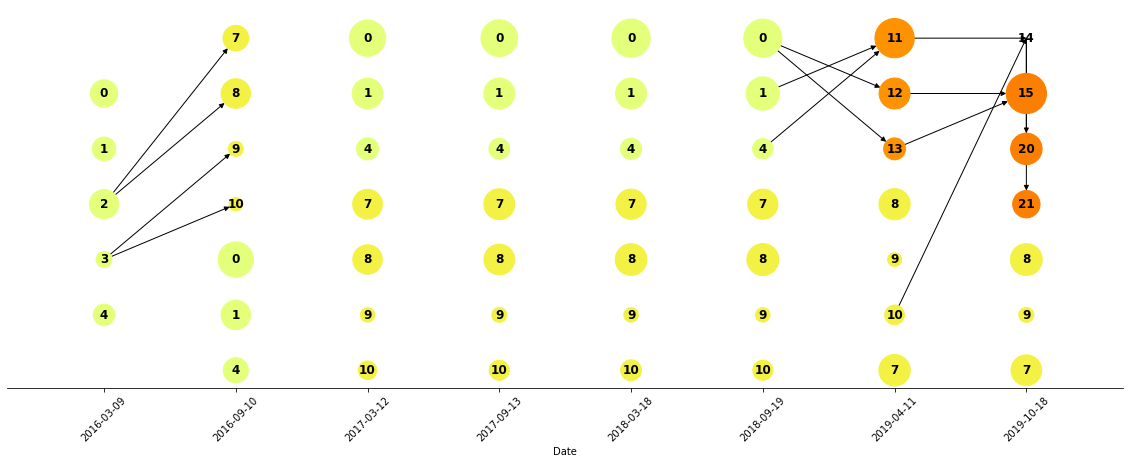

4 optional splits (by volume criterion), only {15: (26, 27)} splits performed.


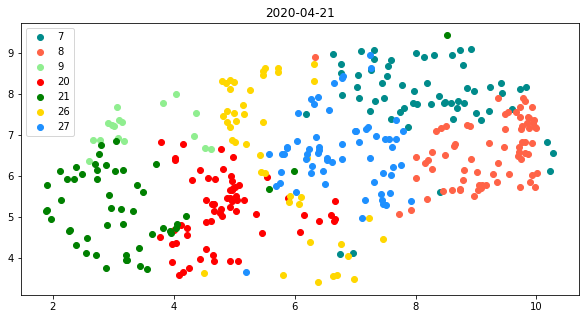

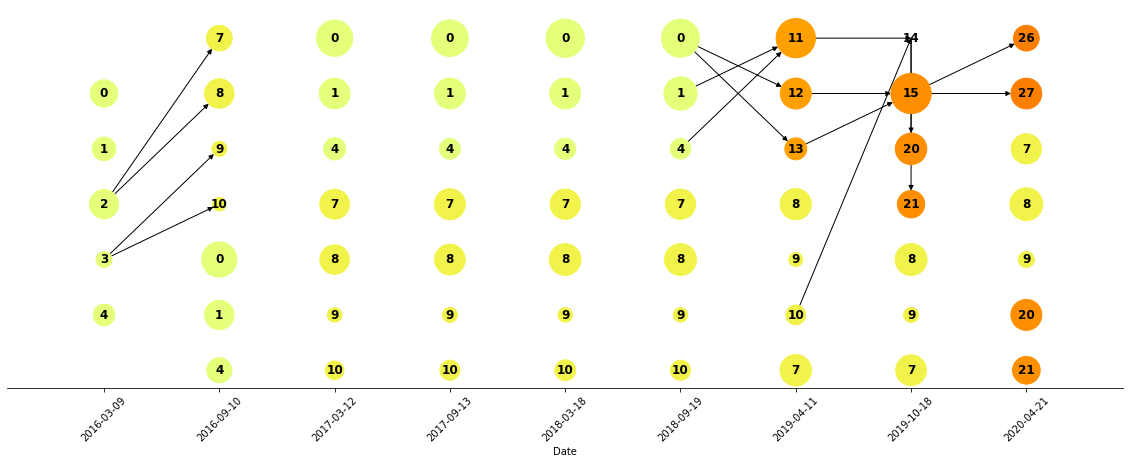

1 optional splits (by volume criterion), only {7: (28, 29)} splits performed.


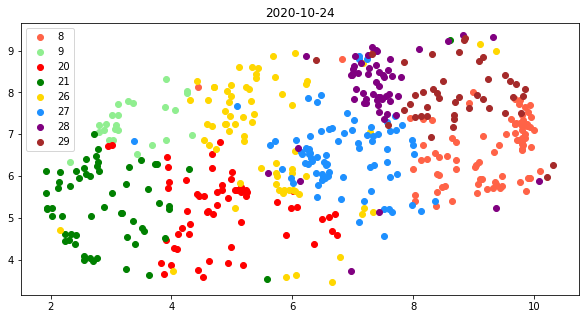

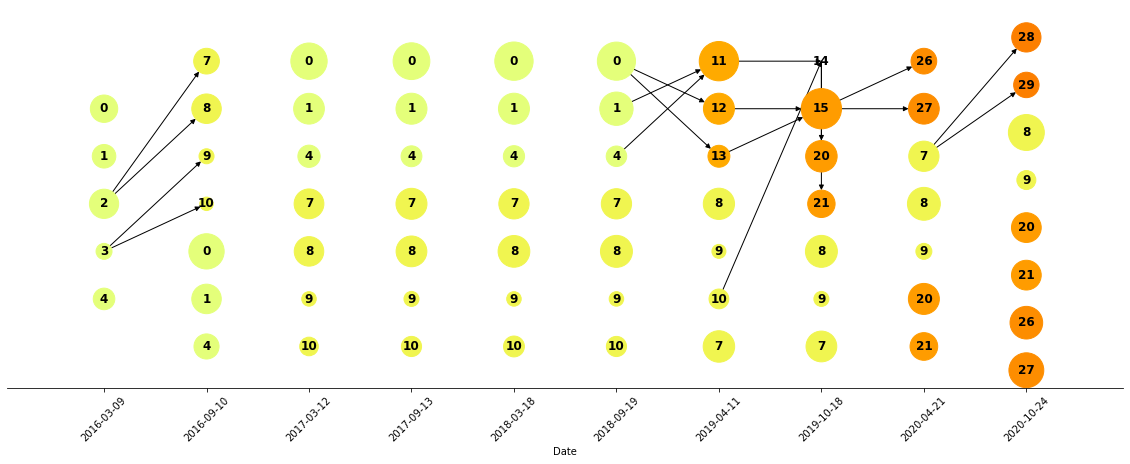

1 optional splits (by volume criterion), only {} splits performed.


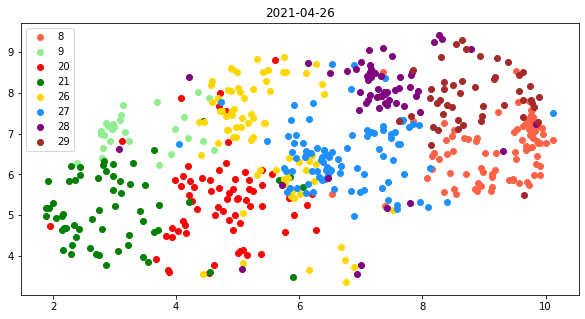

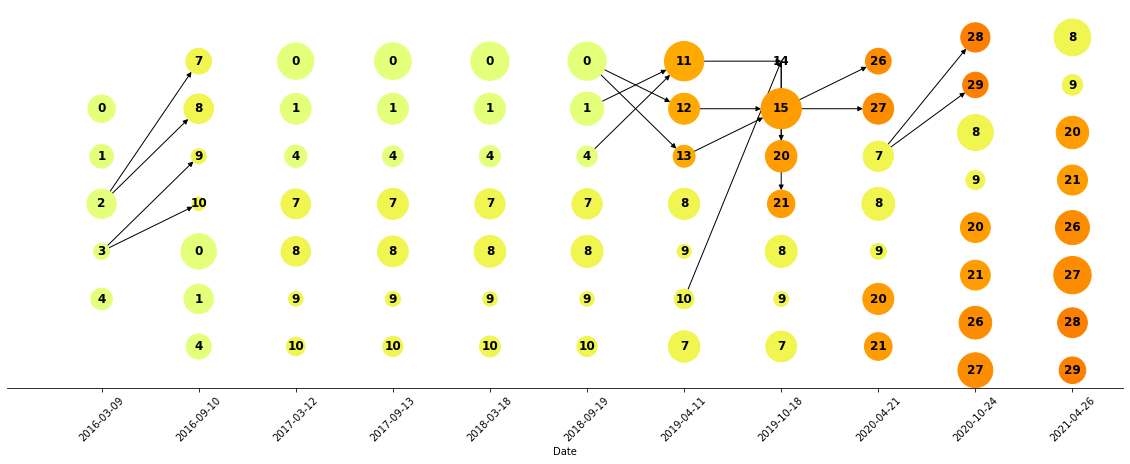

2 optional splits (by volume criterion), only {} splits performed.


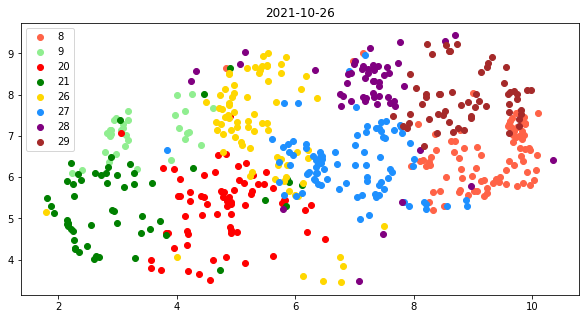

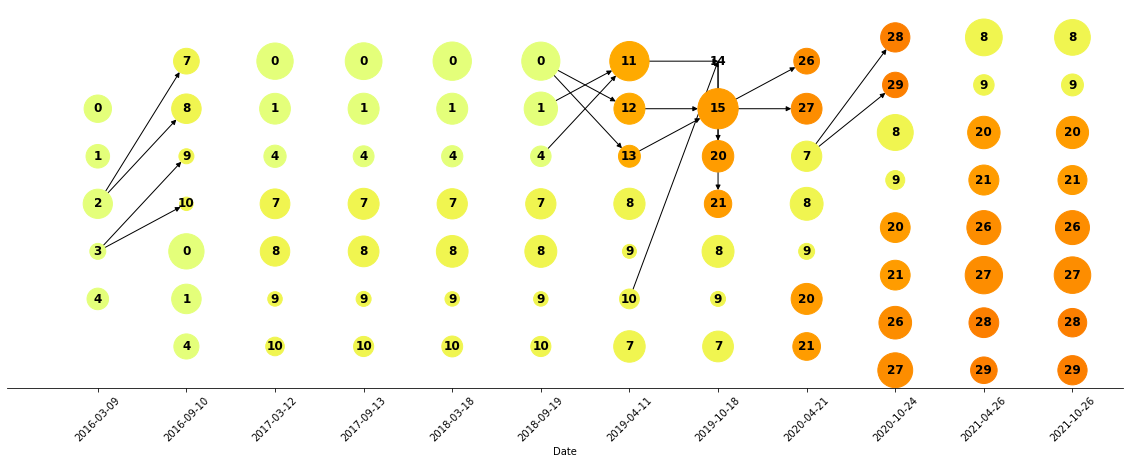

3 optional splits (by volume criterion), only {8: (30, 31)} splits performed.


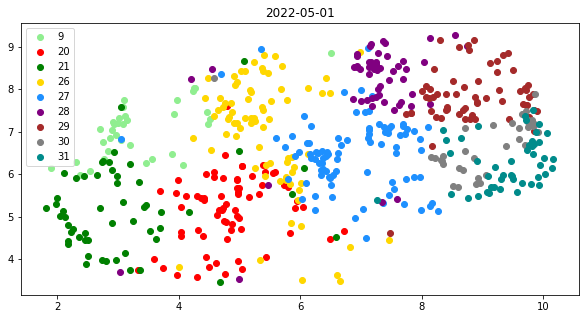

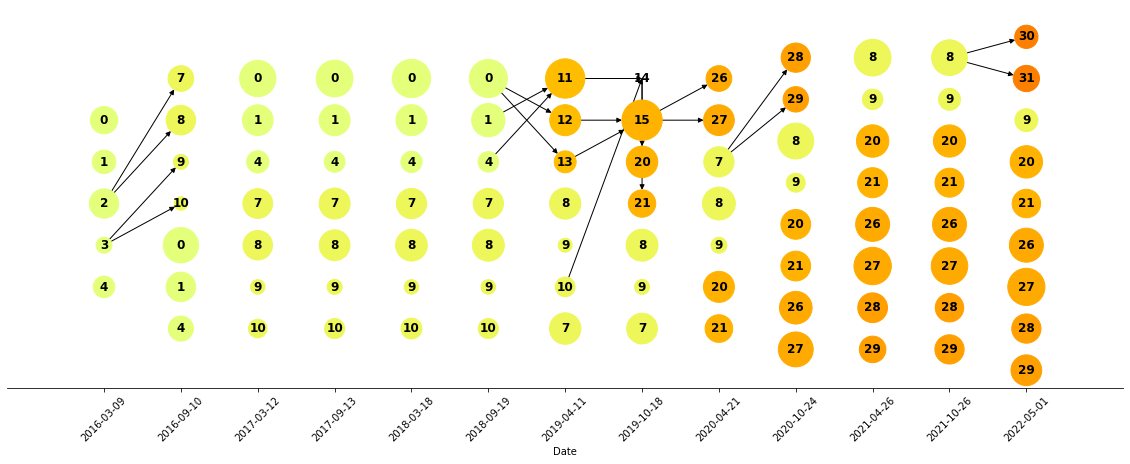

In [14]:
for i, data_i in data.iloc[first_timestep + 1:].iterrows():
    # transform current timestep text
    sentences, clean_sentences = sentence_preprocess(data_i['text'])
    embeddings = bert_model.embed(clean_sentences)
    embeddings_d = umap_d.transform(embeddings)
    embeddings_2 = umap_2.transform(embeddings)
    
    # predict labels
    old_labels = np.array(labels)
    labels = classifier.predict(embeddings_d)
    
    # merge clusters
    merger = merge.NearestCentroidVolume()
    labels, merges = merger.fit_transform(embeddings_d, labels)
    
    # split clusters
    splitter = split.KMeansVolume()
    labels, splits = splitter.fit_transform(embeddings_d, labels)
    
    # fit a new classifier based on current clusters
    classifier = classification.SVMClassifier()
    classifier.fit(embeddings_d, labels)
    
    # how a direct clustering would have performed on current data?
    k = len(np.unique(labels))
    clusterer = clustering.KMeansClustering(k=k)
    clusterer.fit(embeddings_d)
    possible_labels = clusterer.get_labels()
    k = 5
    clusterer = clustering.KMeansClustering(k=k)
    clusterer.fit(embeddings_d)
    possible5_labels = clusterer.get_labels()

    # evaluate clustering methods
    sil.append(silhouette_score(embeddings_d, labels))
    possible_sil.append(silhouette_score(embeddings_d, possible_labels))
    possible5_sil.append(silhouette_score(embeddings_d, possible5_labels))
    
    # update grpah
    counter = Counter(labels)
    for m in merges.items():
        # add node for merged cluster, and draw an edge from original clusters to merged one.
        G.add_nodes_from([(m[0], {'t': i, 
                                  'c': i,
                                  's': counter[m[0]],
                                  'name': m[0]
                                 }
                          )])
        # find latest version of m[1][j]
        source1 = latest_version(G, m[1][0], OFFSET)
        source2 = latest_version(G, m[1][1], OFFSET)
        G.add_edge(source1, m[0])
        G.add_edge(source2, m[0])

    for s in splits.items():
        # add nodes for split clusters, and draw an edge from original cluster to each of its splits.
        G.add_nodes_from([(s[1][0], {'t': i,
                                     'c': i,
                                     's': counter[s[1][0]],
                                     'name': s[1][0]
                                    })])
        G.add_nodes_from([(s[1][1], {'t': i,
                                     'c': i,
                                     's': counter[s[1][1]],
                                     'name': s[1][1]
                                    })])
        # find latest version (node) of s[0]
        source = latest_version(G, s[0], OFFSET)
        G.add_edge(source, s[1][0])
        G.add_edge(source, s[1][1])
        
    for v in set(labels).intersection(set(old_labels)):
        # add node for unchanged clusters
        G.add_nodes_from([(v + (i + 1) * OFFSET, {'t': i,
                                                  'c': G.nodes[v]['c'],
                                                  's': counter[v],
                                                  'name': v
                                                 })])
        # G.add_edge(v, v + (i + 1) * OFFSET)
    
    # plot
    plot_scatter(embeddings_2, labels, data_i['date'])
    plot_graph(G, first_timestep)

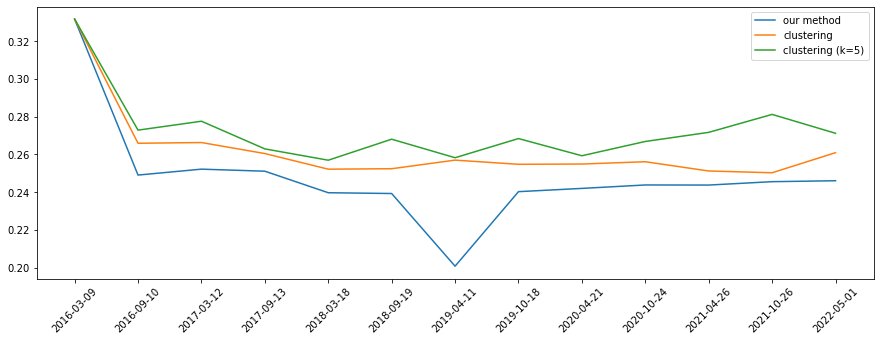

In [15]:
plt.figure(figsize=(15,5))
plt.plot(range(len(sil)), sil, label='our method')
plt.plot(range(len(sil)), possible_sil, label='clustering')
plt.plot(range(len(sil)), possible5_sil, label='clustering (k=5)')
plt.xticks(ticks=range(len(sil)), labels=data.iloc[first_timestep:]['date'], rotation=45)
plt.legend()
plt.show()

In [16]:
common = common_words(clean_sentences, labels, k=15)

topic = 9


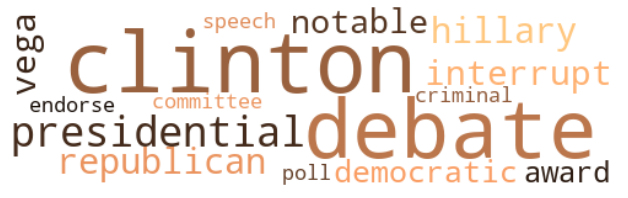

topic = 26


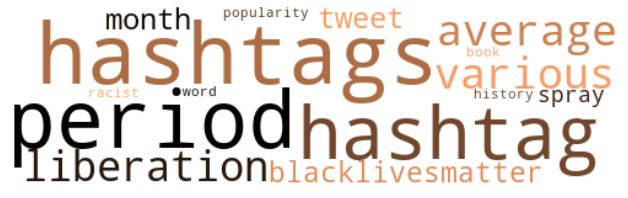

topic = 27


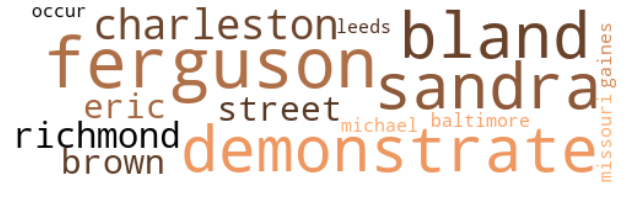

In [17]:
for topic in [9, 26, 27]:
    print(f'topic = {topic}')
    word_cloud(common[topic])

# TODO:
* maybe skip the first timestep (not enough sentences) (V) - looks better from second one
* deal with 'too easy' split and merge (I added another criterion to splitting based on BIC. The problem with BIC is that it is not a criterion but a measure. So I used the deviation from mean out of all bic to see if a split is "obvious" or not).
* Think about other criterions which are more robust and do not use a hueristic threshold.

* Cluster at each timestep. evaluate clustering by my method vs the direct clustering. plot at the end (V).
* Maybe if there was a merge, don't split this one (at the same timestep)?
* Plot fewer timesteps for presentation. (?)
* Add lemmatization to text preprocess (V) - was very helpful
* Implement one more version for each part (clusterer, classifier, split/merge creitrion). For the later maybe a silhouette score (would this prevent merged clusters to split in the same timestep?)